<h1 align=center><font size = 5>DoorDash Machine Learning Data Science Project</font></h1>

<p>Prepared by: <b>Chukwuemeka Okoli</b></p>

Date prepared: 9th March, 2021    

<hr>


##### Problem Description
Before a consumer places an order on DoorDash, we show the expected delivery time. It is very important for DoorDash
to get this right, as it has a big impact on consumer experience. Order lateness / underprediction of delivery time is of
particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as
overestimating it. Orders that are very early / late are also much worse than those that are only slightly early / late. In this
exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time from
* Start : the time consumer submits the order (`created_at`) to
* End : when the order will be delivered to the consumer (`actual_delivery_time`).

To help with this, we have provided
* historical_data.csv: table of historical deliveries (your training set)
* data_to_predict.csv : data for deliveries that you must predict (label-free test set we will use for evaluation)
* data_description.txt : description of all columns in `historical_data.csv` and details of data_to_predict.csv
<hr>

## Objectives

The objective of this project is to:
- Build a model to predict the total delivery duration seconds between `created_at` and `actual_delivery_time`.

<h2>Table of contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#about_dataset">About the dataset</a></li>
        <li><a href="#understanding_dataset">Understanding the Data</a></li>
        <li><a href="#pre-processing">Data Pre-processing</a></li>
        <li><a href="#data_wrangling">Data Wrangling</a></li>
        <li><a href="#exploratory_data_analysis">Exploratory Data Analysis</a></li>
        <li><a href="#feature_engineering">Feature Selection and Engineering</a></li>
        <li><a href="#model_development">Model Development</a></li>
        <li><a href="#model_evaluation">Model Evaluation and Refinement</a></li>
        <li><a href="#interprete_model">Interprete the Model</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ol>
</div>
<br>
<hr>


<div id="about_dataset">
    <h2>About the dataset</h2>
    DoorDash is trying to predict the total delivery duration in seconds using historical data in the attached file &#39;<em>historical_data.csv</em>&#39; received in early 2015 in a subset of cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature.  Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds.  
    <br>
    <br>
    The objective is to build a model to predict the total delivery duration seconds value. This is clearly a supervised learning task, since we are given labeled training data, and it is a typical regression task since the objective is to predict a value. More specifically, this is a <i>multiple regression</i> problem, since we are using multiple features to make a prediction. I will assume that there is no continuous flow of data coming into the system hence no need to adjust to changing data rapidly, so plain batch learning is fine for this project.
    <br>
</div>


<div id="understanding_dataset">
    <h2>Understanding the Data</h2> 
</div>

##### Time features
- market_id: A city/region in which DoorDash operates, e.g., Los Angeles
- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash
- actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

##### Store features 
- store_id: an id representing the restaurant the order was submitted for
- store_primary_category: cuisine category of the restaurant, e.g., italian, asian
- order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

##### Order features
- total_items: total number of items in the order
- subtotal: total value of the order submitted (in cents)
- num_distinct_items: number of distinct items included in the order
- min_item_price: price of the item with the least cost in the order (in cents)
- max_item_price: price of the item with the highest cost in the order (in cents)

##### Market features
- created_at (order submission time)
- total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation 
- total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order
- total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

##### Predictions from other models:
- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)



<div id="pre-processing">
    <h2>Data Pre-processing</h2> 
</div>

##### Setup

I will require the following machine learning libraries: *numpy, pandas, scikit-learn*. I will also use *matplotlib* and *seaborn* for visualization.

In [ ]:
# For Transforming date and time
import time
import datetime
from datetime import datetime

# Math module
import math 
import statsmodels.api as sm
from statsmodels.graphics.correlation import plot_corr

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

#from IPython.core.pylabtools import figsize
from scipy import stats

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2.0)
from seaborn import pairplot

# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer

# Transformation Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from tqdm import tnrange, tqdm_notebook
import itertools

##### Load in Data and look at the Data Structure

Load the csv into pandas dataframe:

In [ ]:
#df = pd.read_csv('historical_data.csv')

# take a look at the dataset
#df.head()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/DoorDash Challenge/historical_data.csv'

df = pd.read_csv(path)

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


Each row in this file corresponds to one unique delivery. Each column corresponds to a feature. By looking at the data, we can see a number of issues to solve. First of all, we have a couple of *NaNs* which we have to deal with.

In [ ]:
# description of the data, feature data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

The *info()* method is useful to get a quick description of the data, especially the total number of rows, each attribute's type, and the number of nonnull values. There are 197,428 instances in the dataset. Notice that the *store_primary_category* has only 192,668 nonnull values, meaning that 4,760 categories are missing this feature. We would have to take care of it later. We use the <em>describe</em> method to obtain a statistical summary of the dataframe.

In [ ]:
# statistics for each column
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


The total delivery duration is the difference between the time order was created `created_at` and the time delivery took place `actual_delivery_time`. We have to format the `total_delivery_duration` to the float data type for ease of computation. We then add the new column to the dataframe.

In [ ]:
# sum of all the NaNs
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [ ]:
# assign column names to `names`
names = df.columns

print(names)

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')


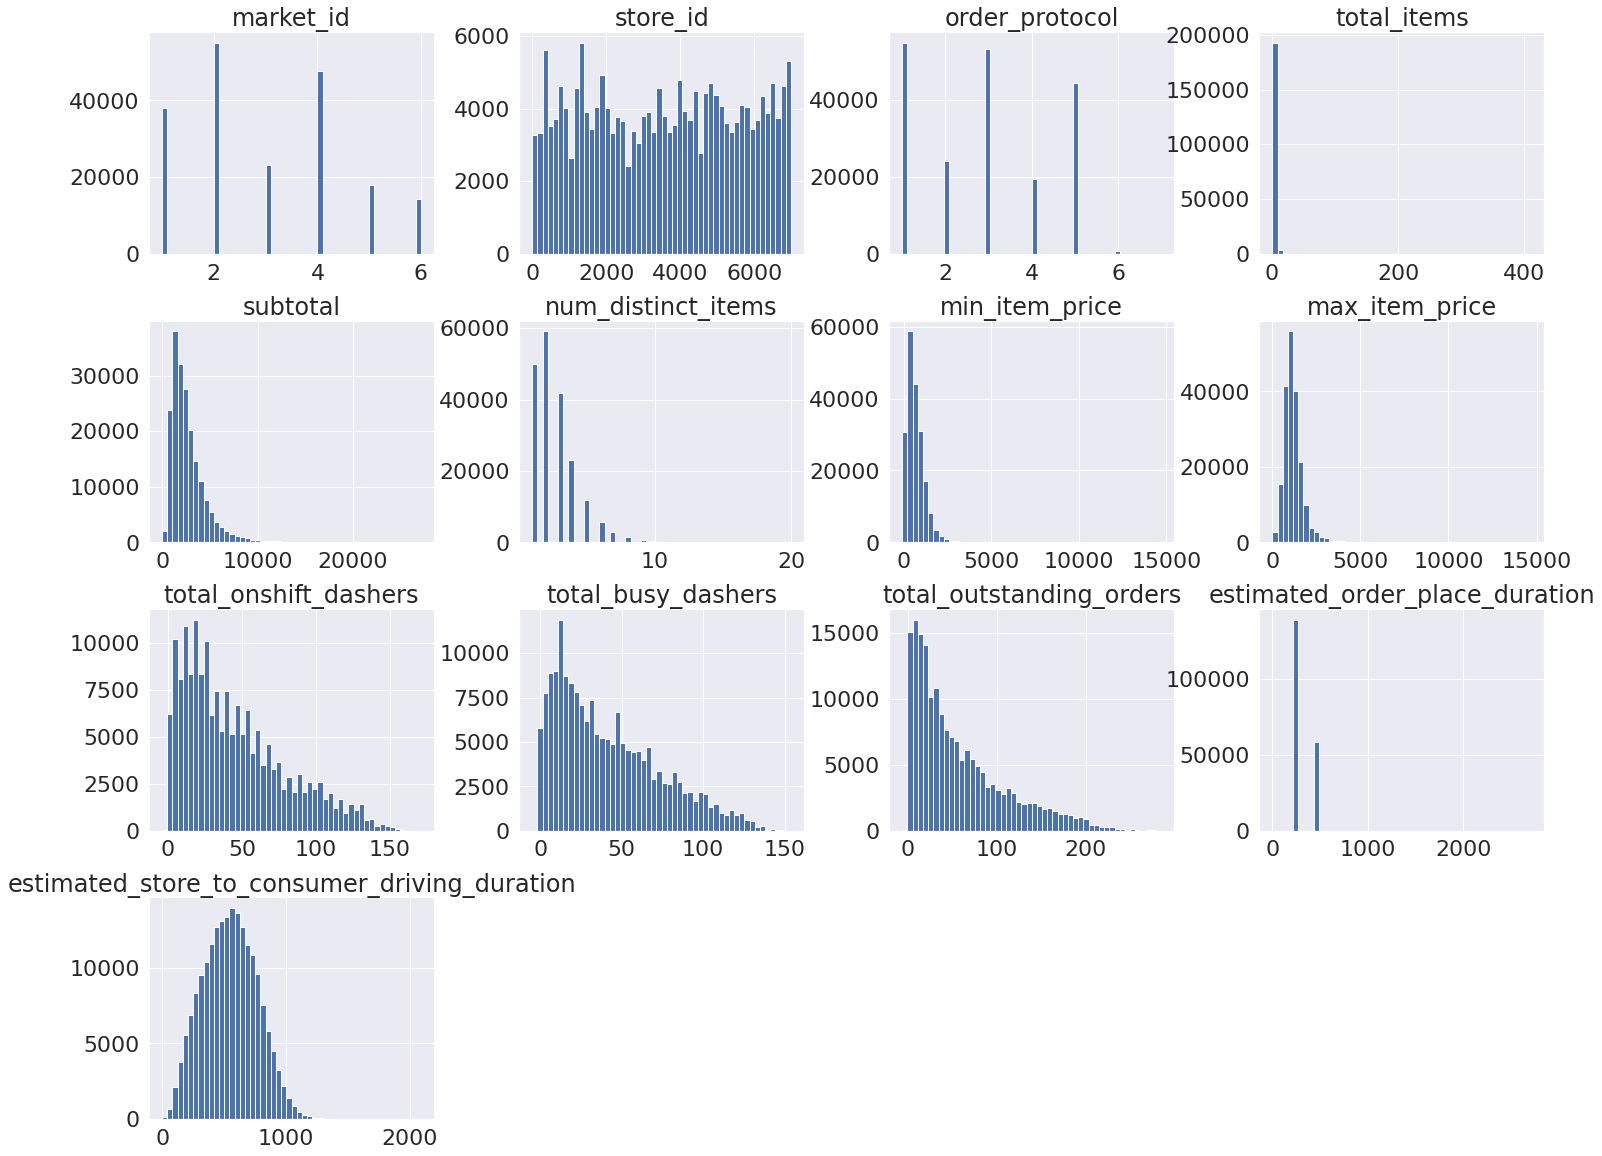

In [ ]:
# histogram of each numerical attribute
df.hist(bins=50, figsize=(25,20))
plt.show()

A histogram gives us a feel of the data we are dealing with. We notice that the features have different scales, many histogram are <em>tail-heavy</em> - they extend further to the right of the median than to the left. 

<div id="data_wrangling">
    <h2>Data Wrangling</h2> 
</div>

In this section, I will try to visualize the data and check for outliers and anomalies in the dataset.

Text(0.5, 1.0, 'market_id')

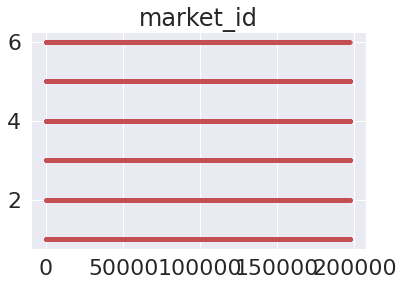

In [ ]:
# market_id
plt.plot(df[names[0]],'r.')
plt.title(names[0])

Text(0.5, 1.0, 'store_id')

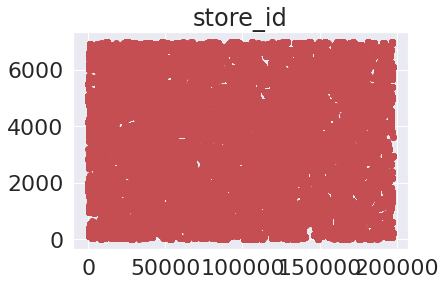

In [ ]:
# store_id
plt.plot(df[names[3]],'ro')
plt.title(names[3])

Text(0.5, 1.0, 'order_protocol')

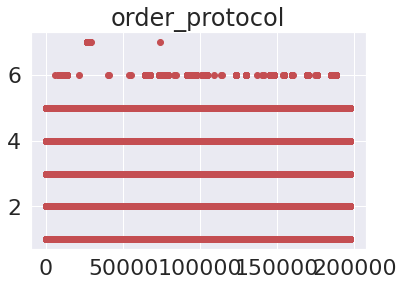

In [ ]:
# order protocol
plt.plot(df[names[5]],'ro')
plt.title(names[5])

Text(0.5, 1.0, 'total_items')

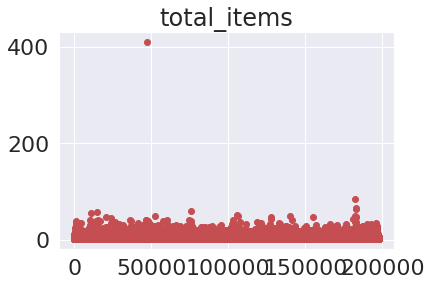

In [ ]:
# total_items
plt.plot(df[names[6]],'ro')
plt.title(names[6])

Text(0.5, 1.0, 'subtotal')

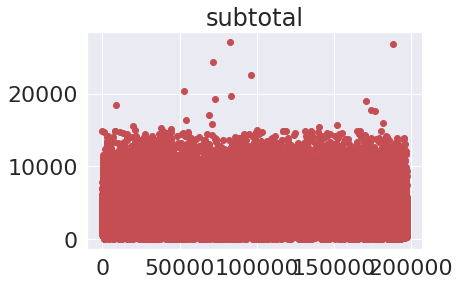

In [ ]:
# subtotal
plt.plot(df[names[7]],'ro')
plt.title(names[7])

Text(0.5, 1.0, 'num_distinct_items')

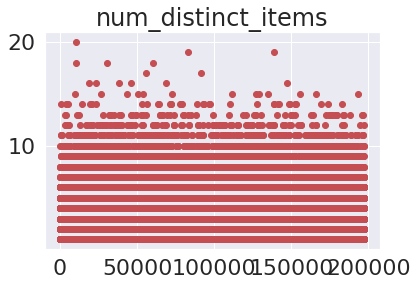

In [ ]:
# num_distict_item
plt.plot(df[names[8]],'ro')
plt.title(names[8])

Text(0.5, 1.0, 'min_item_price')

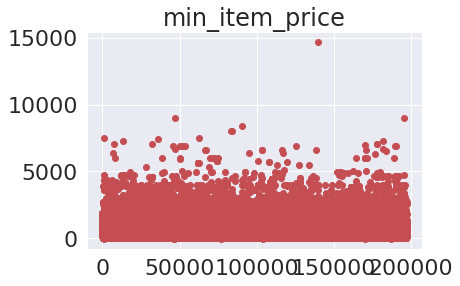

In [ ]:
# min_item_price
plt.plot(df[names[9]],'ro')
plt.title(names[9])

Text(0.5, 1.0, 'max_item_price')

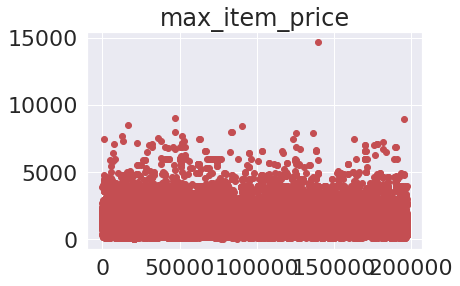

In [ ]:
# max_item_price
plt.plot(df[names[10]],'ro')
plt.title(names[10])

Text(0.5, 1.0, 'total_onshift_dashers')

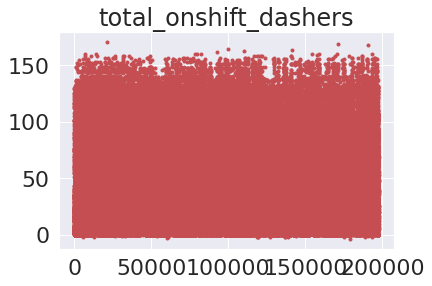

In [ ]:
# total_onshift_dashers
plt.plot(df[names[11]],'r.')
plt.title(names[11])

Text(0.5, 1.0, 'total_busy_dashers')

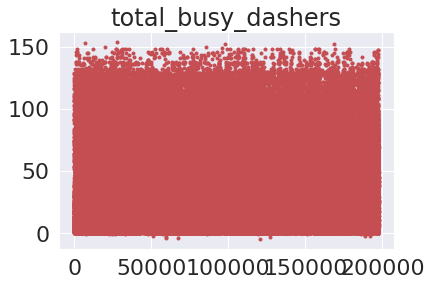

In [ ]:
# total_busy_dashers
plt.plot(df[names[12]],'r.')
plt.title(names[12])

Text(0.5, 1.0, 'total_outstanding_orders')

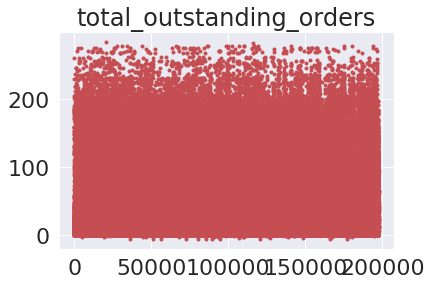

In [ ]:
# total_outstanding_orders
plt.plot(df[names[13]],'r.')
plt.title(names[13])

Text(0.5, 1.0, 'estimated_order_place_duration')

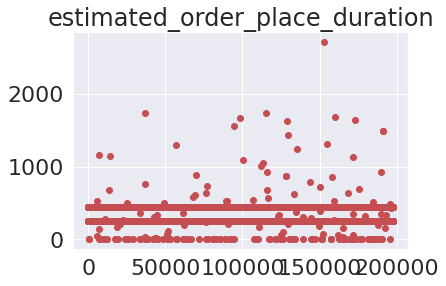

In [ ]:
# estimated_order_place_duration
plt.plot(df[names[14]],'ro')
plt.title(names[14])

Text(0.5, 1.0, 'estimated_store_to_consumer_driving_duration')

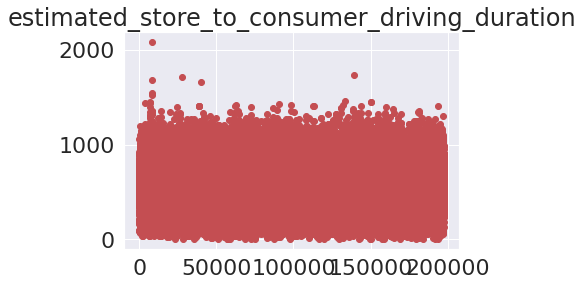

In [ ]:
# estimated_store_to_customer_driving_duration
plt.plot(df[names[15]],'ro')
plt.title(names[15])

In [ ]:
# fixing discrepancy in data
b = df.index[df["num_distinct_items"] == 0].tolist()
sum(df["min_item_price"] > df["max_item_price"])
c = df.index[df["min_item_price"] > df["max_item_price"]]
d = df.index[df["max_item_price"] == max(df["max_item_price"])].tolist()
e = df.index[df["max_item_price"] > df["subtotal"]]
f = df.index[df["total_busy_dashers"] > df["total_onshift_dashers"]]

We can observe the presence of outliers in the data which will make modeling difficult. Outliers can distort our model because they are not indicative of the distribution of the data. 

In [ ]:
# removing outlier in total_items
a = df.index[df["total_items"] == max(df["total_items"])].tolist()
df.drop(a, axis=0, inplace=True)

In [ ]:
# cleaning min_item_price and max_item_price feature
a1 = df.index[(df["min_item_price"] > df["max_item_price"]) & (df["total_items"]==1)].tolist()
type(a1)
list1 = ["min_item_price","max_item_price"]
for n in range(0,len(list1)):
    for i in range(0,len(a1)):
        df[list1[n]][a1[i]] = df["subtotal"][a1[i]]

a2 = df.index[(df["min_item_price"] > df["max_item_price"]) & (df["total_items"] == 2) & ((df["subtotal"] - df["min_item_price"]) < df["min_item_price"])].tolist()
for n in range(0, len(a2)):
    df["max_item_price"][a2[n]] = df["min_item_price"][a2[n]]
    df["min_item_price"][a2[n]] = df["subtotal"][a2[n]] - df["max_item_price"][a2[n]]
    
a3 = df.index[(df["min_item_price"] > df["max_item_price"]) & (df["total_items"] == 2) & ((df["subtotal"] - df["min_item_price"]) > df["min_item_price"])].tolist()
for n in range(0, len(a3)):
    df["max_item_price"][a3[n]] = df["subtotal"][a3[n]] - df["min_item_price"][a3[n]]

a4 = df.index[df["min_item_price"] > df["max_item_price"]].tolist()
for n in range(0, len(a4)):
    tp = df["max_item_price"][a4[n]].copy()
    df["max_item_price"][a4[n]] = df["min_item_price"][a4[n]]
    df["min_item_price"][a4[n]] = tp

a5 = df.index[df["min_item_price"] < 0].tolist()
for n in range(0, len(a5)):
    df["min_item_price"][a5[n]] = abs(df["min_item_price"][a5[n]])


In [ ]:
# cleaning total_onshift_dasher and total_busy_dasher_feature
a6 = df.index[df["total_onshift_dashers"] < 0].tolist()
for n in range(0, len(a6)):
    df["total_onshift_dashers"][a6[n]] = abs(df["total_onshift_dashers"][a6[n]])
    
a7 = df.index[df["total_busy_dashers"] > df["total_onshift_dashers"]].tolist()
for n in range(0, len(a7)):
    tp1 = df["total_onshift_dashers"][a7[n]].copy()
    df["total_onshift_dashers"][a7[n]] = df["total_busy_dashers"][a7[n]]
    df["total_busy_dashers"][a7[n]] = tp1

a8 = df.index[df["total_outstanding_orders"] < 0].tolist()   
for n in range(0, len(a8)):
    df["total_outstanding_orders"][a8[n]] = abs(df["total_outstanding_orders"][a8[n]])

# removing null rows from actual_delivery_time
a9 = df.index[df["actual_delivery_time"].isna()].tolist()
for n in range(0, len(a9)):
    df.drop(a9[n], inplace=True)
a10 = df.index[df["max_item_price"] > df["subtotal"]].tolist()
for n in range(0, len(a10)):
    df["subtotal"][a10[n]] = np.mean(df["max_item_price"][a10[n]] + df["min_item_price"][a10[n]]) * df["total_items"][a10[n]]

After addressing the discrepancies in the data, I then created new features from the existing data.

In [ ]:
# new features creation
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"], format='%Y-%m-%d %H:%M:%S', errors='raise')
df["created_at"] = pd.to_datetime(df["created_at"], format='%Y-%m-%d %H:%M:%S', errors='raise')
df["total_delivery_duration"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds()
df["created_at_hour"] = (df["created_at"].dt.hour)*3600
df["created_at_minutes"] = (df["created_at"].dt.minute)*60
df["created_at_seconds"] = df["created_at"].dt.second
df["created_at_dayofweek"] = df["created_at"].dt.dayofweek
pd.set_option("display.max_columns", 6)
df["created_at_time"] = df["created_at_hour"] + df["created_at_minutes"] + df["created_at_seconds"]
df[["created_at","created_at_hour","created_at_minutes","created_at_seconds","created_at_dayofweek","created_at_time"]].head()
df["created_at_sine_time"] = np.sin(2*np.pi*df["created_at_time"]/(24*60*60))
df["created_at_cos_time"] = np.cos(2*np.pi*df["created_at_time"]/(24*60*60))
df["total_available_dasher"] = df["total_onshift_dashers"] - df["total_busy_dashers"]

##### Dealing with Missing Values 

Since the data has some missing values, we have to deal with them by first looking at the percentage of missing values in each column. The following function calculates the number of missing values and the percentage of the total values that are missing for each column.

In [ ]:
# function to calculate missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(df)

Your selected dataframe has 25 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
total_onshift_dashers,16262,8.2
total_busy_dashers,16262,8.2
total_outstanding_orders,16262,8.2
total_available_dasher,16262,8.2
store_primary_category,4760,2.4
order_protocol,995,0.5
market_id,987,0.5
estimated_store_to_consumer_driving_duration,526,0.3


We can see that we have a low percentage of missing values, less than 10%. If a column has a high percentage of missing values, then it probably will not be useful. Similarly, if there are missing values in our target variable, it is best to drop that row containing the missing values. For this project, I will remove any column with more than 50% missing values. I will also be dropping features that are not needed. 

In [ ]:
# first create a copy of the data
dash_df = df.copy()

In [ ]:
# dropping features not needed and removing rows with null values
dash_df.drop("actual_delivery_time", axis=1, inplace=True)
dash_df.drop("created_at", axis=1, inplace=True)
dash_df.dropna(how ='any',axis=0, inplace=True)

# reset index, because we dropped some rows
dash_df = dash_df.reset_index(drop=True)

Since the sample size is large enough, we can drop data without substantial loss of statistical power. We have to be careful when removing observations with missing values because that can produce a bias in the model. But by observing the data, we can observe that the missing value are not random.   

In [ ]:
# check the wrangled data
missing_values_table(dash_df)

Your selected dataframe has 23 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
# inspect the first five rows
dash_df.head(5)

,market_id,store_id,store_primary_category,...,created_at_sine_time,created_at_cos_time,total_available_dasher
0,1.0,1845,american,...,-0.405607,0.914048,19.0
1,2.0,5477,mexican,...,-0.539445,0.842021,1.0
2,2.0,5477,indian,...,0.050520,0.998723,2.0
3,1.0,2841,italian,...,0.810979,0.585076,1.0
4,1.0,2841,italian,...,0.546833,0.837242,0.0


<div id="exploratory_data_analysis">
    <h2>Exploratory Data Analysis</h2>
</div>

In this section, we will be looking at what our data can tell us. Can we draw up relationships between variables or is there an anomaly that we can observe. Exploratory Data Analysis is usually open-ended but the goal of EDA is to determine what our data can tell us! We will be looking for patterns, trends, relationships in our data. This will be interesting themselves (for instance finding a correlation between two variables) or they can be used to inform modeling decisions like which features to include.   

Let's explore some relationship between the following columns: `estimated_order_place_duration`, `total_onshift_dashers`, `total_busy_dashers`, `estimated_order_place_duration`, `estimated_store_to_consumer_driving_duration`. The aim is to find out whether they are related to the `total_delivery_duration`. 

In [ ]:
# correlation between selected attributes
dash_df[['total_outstanding_orders', 'total_onshift_dashers', 'total_busy_dashers', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_delivery_duration']].corr()

,total_outstanding_orders,total_onshift_dashers,total_busy_dashers,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
total_outstanding_orders,1.000000,0.922219,0.959702,-0.174660,0.039151,0.122033
total_onshift_dashers,0.922219,1.000000,0.965206,-0.194496,0.045973,0.042240
total_busy_dashers,0.959702,0.965206,1.000000,-0.189804,0.043629,0.067777
estimated_order_place_duration,-0.174660,-0.194496,-0.189804,1.000000,-0.021979,0.068715
estimated_store_to_consumer_driving_duration,0.039151,0.045973,0.043629,-0.021979,1.000000,0.158361
total_delivery_duration,0.122033,0.042240,0.067777,0.068715,0.158361,1.000000


(0.0, 50000.0)

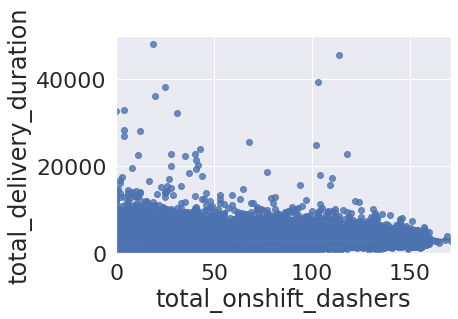

In [ ]:
# total onshift dashers as a potential predictor of total delivery duration
sns.regplot(x='total_onshift_dashers', y='total_delivery_duration', data=dash_df)
plt.ylim(0, 50000)

(0.0, 5000.0)

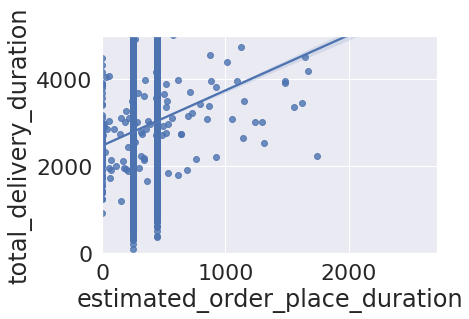

In [ ]:
# estimated order place duration as a potential predictor of total delivery duration
sns.regplot(x='estimated_order_place_duration', y='total_delivery_duration', data=dash_df)
plt.ylim(0, 5000)

(0.0, 392567.9)

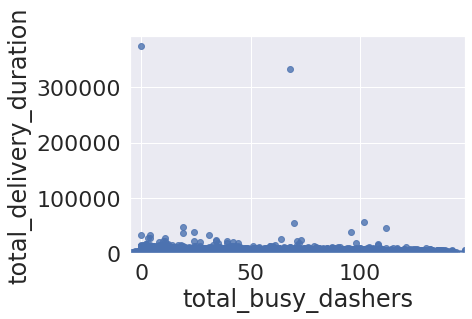

In [ ]:
# total busy dashers as a potential predictor of total delivery duration
sns.regplot(x='total_busy_dashers', y='total_delivery_duration', data=dash_df)
plt.ylim(0,)

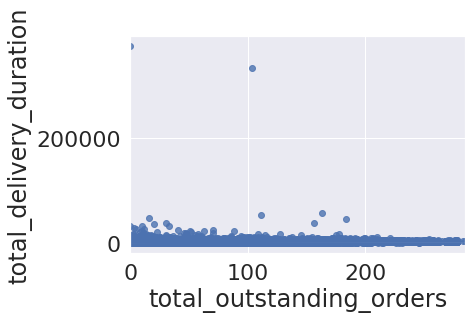

In [ ]:
# total outstanding order as a potential predictor of total delivery duration
sns.regplot(x='total_outstanding_orders', y='total_delivery_duration', data=df)

Let's plot a multivariate plot to visualize the interaction between variables.

In [ ]:
# correlation in the data
dash_df.corr()

,market_id,store_id,order_protocol,...,created_at_sine_time,created_at_cos_time,total_available_dasher
market_id,1.000000,0.044914,-0.013338,...,0.005266,0.016844,0.128017
store_id,0.044914,1.000000,0.013314,...,-0.012387,-0.007129,0.000828
order_protocol,-0.013338,0.013314,1.000000,...,-0.003655,0.013555,0.071222
total_items,0.004350,-0.008568,0.007172,...,0.039615,0.026575,0.013487
subtotal,-0.000357,-0.012636,-0.052854,...,0.136031,0.127675,0.052936
num_distinct_items,0.015511,-0.013186,-0.023949,...,0.076602,0.059218,0.027239
min_item_price,-0.010903,-0.006896,-0.043707,...,0.058304,0.043978,0.016587
max_item_price,-0.007343,-0.016914,-0.090334,...,0.177460,0.127244,0.056581
total_onshift_dashers,0.083658,-0.022382,0.150847,...,0.360029,0.197273,0.564318
total_busy_dashers,0.055152,-0.025866,0.150002,...,0.362190,0.187081,0.328807


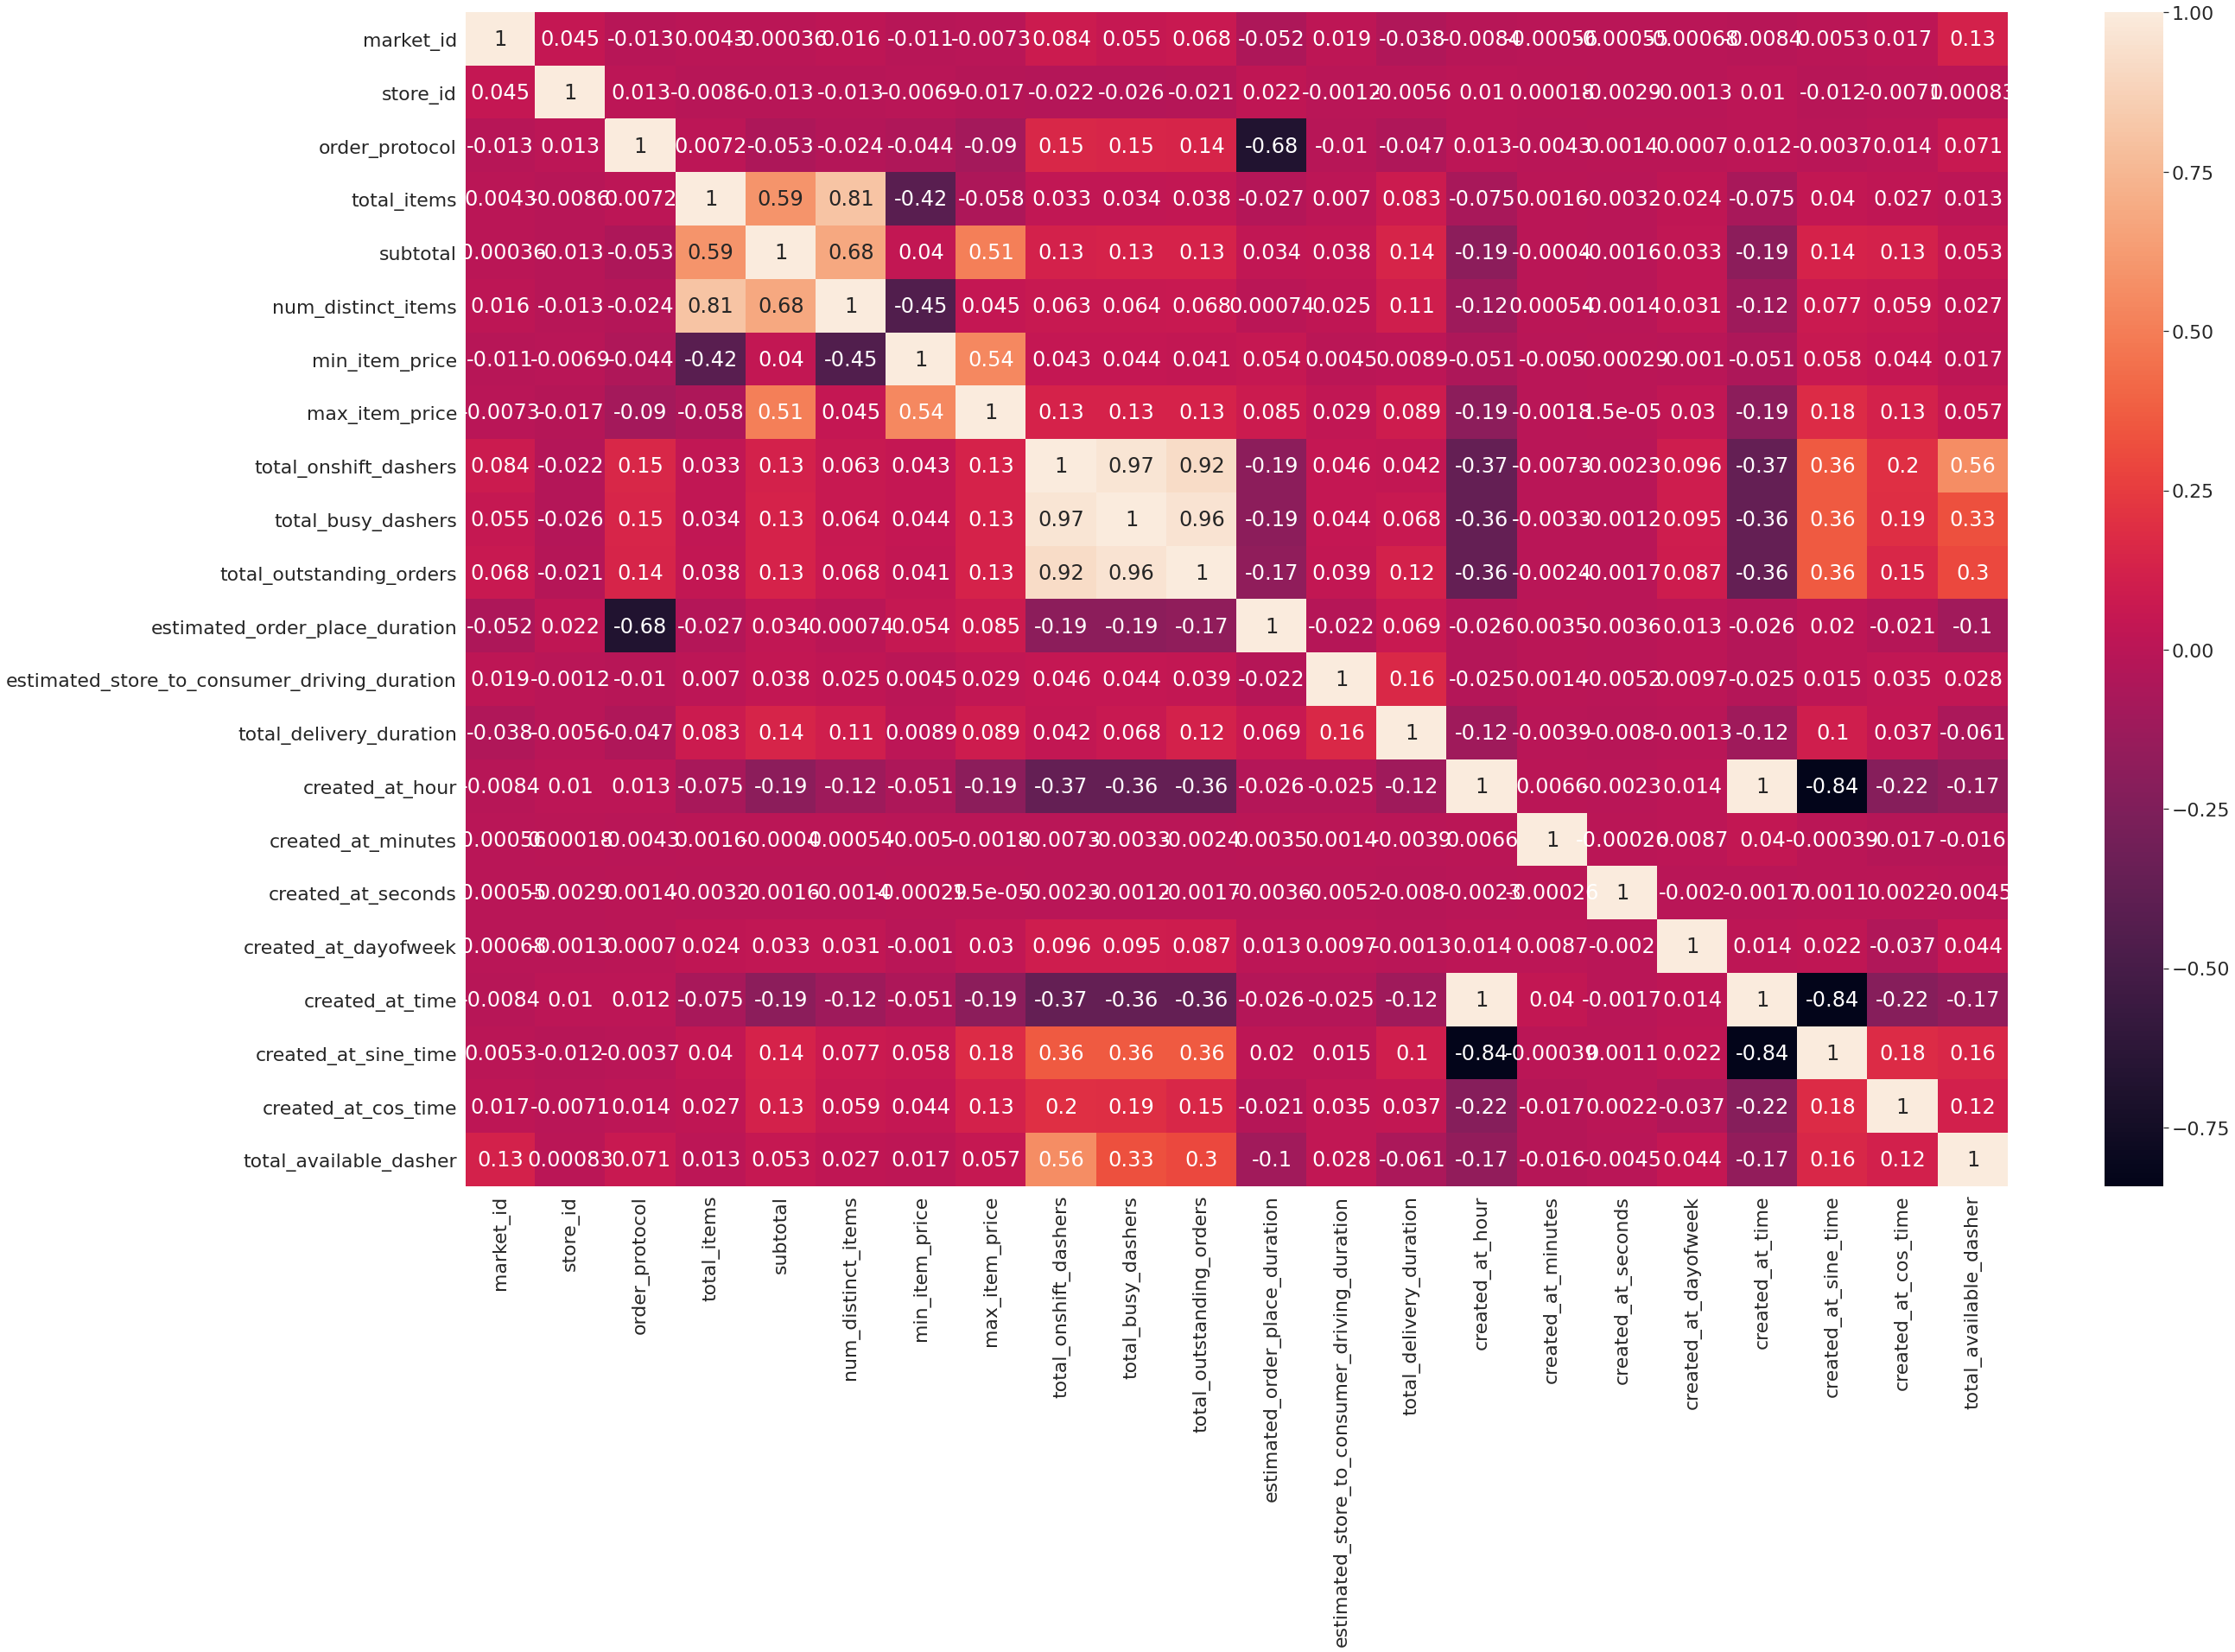

In [ ]:
# correlation matrix 
plt.figure(figsize=(40, 25))

corrMatrix = dash_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Correlation and Causation

<h4>total_onshift_dasher vs. total_delivery_duration</h4>

In [ ]:
# correlation of total_onshift_dasher to total_delivery_duration
pearson_coef, p_value = stats.pearsonr(dash_df['total_onshift_dashers'], dash_df['total_delivery_duration'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.042239839647207136  with a P-value of P = 3.094179448576894e-70


<h5>Conclusion:</h5>
<p>Since the p-value is < 0.001, the correlation between total_onshift_dasher and total_delivery_duration is statistically significant, although the linear relationship isn't extremely strong (~0.047)</p>

<h4>total_busy_dashers vs. total_delivery_duration</h4>

In [ ]:
# correlation of total_busy_dasher to total_delivery_duration
pearson_coef, p_value = stats.pearsonr(dash_df['total_busy_dashers'], dash_df['total_delivery_duration'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.067776781560755  with a P-value of P = 5.104988950283267e-178


<h5>Conclusion:</h5>
<p>Since the p-value is < 0.001, the correlation between total_busy_dasher and total_delivery_duration is statistically significant, although the linear relationship isn't extremely strong (~0.060)</p>

<h4>total_outstanding_orders vs. total_delivery_duration</h4>

In [ ]:
# correlation of total_outstanding_orders to total_delivery_duration
pearson_coef, p_value = stats.pearsonr(dash_df['total_outstanding_orders'], dash_df['total_delivery_duration'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.1220334314855203  with a P-value of P = 0.0


<h5>Conclusion:</h5>
<p>Since the p-value is < 0.0, the correlation between total_outstanding_orders and total_delivery_duration is statistically significant, although the linear relationship isn't extremely strong (~0.122)</p>

<h4> estimated_store_to_customer_driving_duration vs. total_delivery_duration</h4>

In [ ]:
# correlation of estimated_order_place_duration to total_delivery_duration
pearson_coef, p_value = stats.pearsonr(dash_df['estimated_order_place_duration'], dash_df['total_delivery_duration'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.06871519650036283  with a P-value of P = 6.169664109457329e-183


<h5>Conclusion:</h5>
<p>Since the p-value is < 0.001, the correlation between estimated_order_place_duration and total_delivery_duration is statistically significant, although the linear relationship isn't extremely strong (~0.068)</p>

<p>We now have a better idea of what our data looks like and which variables are important to take into account when predicting the total delivery duration. We can now do some feature engineering to come up with more features that can help our analysis.</p>

<div id="feature_engineering">
    <h3>Feature Selection and Engineering</h3> 
</div>

We can calculate the feature importance to each input features based on how well they are useful at predicting a target variable. Feature importance can help us in a predictive project by providing insight in the data, the model, and feature selection which can improve efficiency and effectiveness of our predictive model. The score assigned to input features to a predictive model can highlight which features are most relevant to the target variable and least important to the model when making a prediction. With feature selection before modeling our data, we can:
- reduce overfitting
- improve accuracy
- reduce training time

#### Handling Categorical Features

In [ ]:
# assigning dummy variables for categorical features
cat_columns = ["market_id", "store_primary_category", "order_protocol", "created_at_dayofweek"]
dash_df_dumm = pd.get_dummies(dash_df, prefix_sep="__", columns=cat_columns)
dash_df_dumm.info()

# dash_df_dum["total_available_dasher"] = dash_df_dum["total_onshift_dashers"] - dash_df_dum["total_busy_dashers"]

# drop_columns = ["market_id", "store_primary_category", "order_protocol", "created_at_dayofweek",]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175776 entries, 0 to 175775
Columns: 112 entries, store_id to created_at_dayofweek__6
dtypes: float64(8), int64(11), uint8(93)
memory usage: 41.1 MB


<div id="model_development">
    <h3>Model Development</h3> 
</div>

I split my dataset randomly in train and test set (70:30 percent ratio).i.e., 70% training and 30% testing sets and went ahead to scale my predictor features. 

In [ ]:
# training and testing (or validation 'valid') data 
train_data, valid_data = train_test_split(dash_df_dumm, test_size=0.3, random_state=668)

# divide for predictors and response
train_y = train_data["total_delivery_duration"]
train_y = pd.DataFrame(train_y)
train_x = train_data.drop("total_delivery_duration", axis=1)

valid_y = valid_data["total_delivery_duration"]  
valid_x = valid_data.drop("total_delivery_duration", axis=1)
valid_y = pd.DataFrame(valid_y)
type(train_x)

pandas.core.frame.DataFrame

In [ ]:
print("number of test samples:", valid_x.shape[0])
print("number of training samples:", train_x.shape[0])

number of test samples: 52733
number of training samples: 123043


##### Scaling Data

In [ ]:
# scaling dataset
scaler = MinMaxScaler()
scaler.fit(train_x)
names1 = dash_df_dumm.columns
names1[11]

Column_names = np.delete(names1,(11),axis=0)
train_x = scaler.transform(train_x)
train_x = pd.DataFrame(train_x, columns=Column_names)
valid_x = scaler.transform(valid_x)
valid_x = pd.DataFrame(valid_x, columns=Column_names)
temp_test = valid_x.copy()
temp_train = train_x.copy()

In [ ]:
# subset selection
def fit_linear_reg(X,Y):
    # fit linear regression model and return RSS and R squared values
    m = len(Y)
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y, model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    R_squared_adj = 1 - ( (1 - R_squared)*(m-1)/(m-len(X.columns) -1))
    return RSS, R_squared, R_squared_adj

k = len(Column_names)

remaining_features = list(train_x.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()
# looping over k = 1 to k = 111 features in Predictors
for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(train_x[list(combo) + features], train_y)   # store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    # updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    # saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

[(1, ['estimated_store_to_consumer_driving_duration'], 158052745511),
 (2,
  ['estimated_store_to_consumer_driving_duration', 'subtotal'],
  151686010471),
 (3,
  ['estimated_store_to_consumer_driving_duration',
   'subtotal',
   'total_outstanding_orders'],
  148295400186),
 (4,
  ['estimated_store_to_consumer_driving_duration',
   'subtotal',
   'total_outstanding_orders',
   'total_onshift_dashers'],
  136502320165)]

In [ ]:
# finding the optimal subset
df11= pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df11['numb_features'] = df11.index

m = len(train_y)
p = len(Column_names)
hat_sigma_squared = (1/(m - p -1)) * min(df11['RSS'])

# computing
df11['C_p'] = (1/m) * (df11['RSS'] + 2 * df11['numb_features'] * hat_sigma_squared )
df11['AIC'] = (1/(m*hat_sigma_squared)) * (df11['RSS'] + 2 * df11['numb_features'] * hat_sigma_squared )
df11['BIC'] = (1/(m*hat_sigma_squared)) * (df11['RSS'] +  np.log(m) * df11['numb_features'] * hat_sigma_squared )
df11['R_squared_adj'] = 1 - ( (1 - df11['R_squared'])*(m-1)/(m-df11['numb_features'] -1))

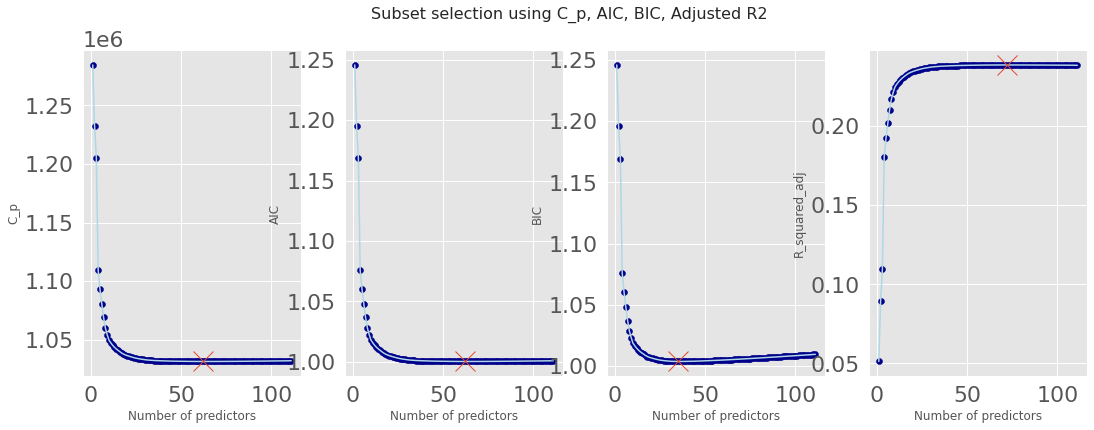

In [ ]:
# plot
variables = ['C_p', 'AIC','BIC','R_squared_adj']
plt.style.use('ggplot')
fig = plt.figure(figsize = (18,6))

for i, v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df11['numb_features'], df11[v], color = 'lightblue')
    ax.scatter(df11['numb_features'], df11[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df11[v].idxmax(),df11[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df11[v].idxmin(),df11[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

In [ ]:
s1 = df11.index[df11['AIC'] == min(df11['AIC'])]
s2 = df11.index[df11['C_p'] == min(df11['C_p'])]
s3 = df11.index[df11['BIC'] == min(df11['BIC'])]
s4 = df11.index[df11['R_squared_adj'] == max(df11['R_squared_adj'])]


In [ ]:
# linear model
Sig_Features = df11['features'][65]
train_x.columns
train_x = train_x[Sig_Features]
type(train_x)
lin_model = fit_linear_reg(train_x, train_y)
pd.DataFrame(lin_model, index=("RSS","R_squared","R_Squared_adj"), columns=["Values"])

,Values
RSS,1.267823e+11
R_squared,2.389269e-01
R_Squared_adj,2.385247e-01


In [ ]:
# linear model
m = len(train_y)
lin_reg = LinearRegression()
linear_M = lin_reg.fit(train_x, train_y)
RSS = mean_squared_error(train_y,linear_M.predict(train_x))
np.sqrt(RSS)
R_squared = linear_M.score(train_x,train_y)
R_squared_adj = 1 - ( (1 - R_squared)*(m-1)/(m-len(train_x.columns) -1))

from sklearn.model_selection import cross_val_score
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

scores = cross_val_score(lin_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)  ### 10 subsets
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 964.02747267 1015.46816175 1164.28194677 1022.84059644  976.47194388
 1020.23601206  948.67590749  962.80089174  969.35181722 1092.5986012 ]
Mean: 1013.6753351222611
Standard deviation: 64.55091285991247


In [ ]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

tree_model = tree_reg.fit(train_x, train_y)
RSS = mean_squared_error(train_y, tree_model.predict(train_x))
np.sqrt(RSS)
R_squared = tree_model.score(train_x,train_y)
R_squared_adj = 1 - ( (1 - R_squared)*(m-1)/(m-len(train_x.columns) -1))

scores1 = cross_val_score(tree_reg, train_x, train_y, scoring = "neg_mean_squared_error", cv=10)  ### 10 subsets
rmse_scores1 = np.sqrt(-scores1)
display_scores(rmse_scores1)
#np.ravel(train_y)

Scores: [1323.03613157 1507.22393015 1483.62843384 1397.01417492 1414.71666941
 1463.79324971 1422.67554549 1397.83573622 1402.90315296 1522.12437714]
Mean: 1433.4951401415635
Standard deviation: 57.38606927160611


In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_model = forest_reg.fit(train_x, train_y)
RSS = mean_squared_error(train_y,forest_model.predict(train_x))
np.sqrt(RSS)
R_squared = forest_model.score(train_x,train_y)
R_squared_adj = 1 - ( (1 - R_squared)*(m-1)/(m-len(train_x.columns) -1))

scores2 = cross_val_score(forest_reg, train_x, train_y, scoring = "neg_mean_squared_error", cv=10)  ### 10 subsets
rmse_scores2 = np.sqrt(-scores2)
display_scores(rmse_scores2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Scores: [ 931.16438427  987.87207592 1141.58256563 1000.02307013  948.93724291
  979.75772815  919.1948422   932.43625912  943.84744495 1071.23799867]
Mean: 985.6053611949043
Standard deviation: 67.22978872991361


In [ ]:
# XGBoost
#pip install xgboost
import xgboost as xgb
regressor = xgb.XGBRegressor()
xgb_model = regressor.fit(train_x, train_y)
RSS = mean_squared_error(train_y, xgb_model.predict(train_x))
np.sqrt(RSS)
R_squared = xgb_model.score(train_x, train_y)
R_squared_adj = 1 - ( (1 - R_squared)*(m-1)/(m-len(train_x.columns) -1))

scores3 = cross_val_score(regressor, train_x, train_y, scoring = "neg_mean_squared_error", cv=10)  ### 10 subsets
rmse_scores3 = np.sqrt(-scores3)
display_scores(rmse_scores3)

[06:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

<div id="model_evaluation">
    <h3>Model Evaluation and Refinement</h3> 
</div>

##### Hyperparameter Tuning

In [ ]:
# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
regressor = xgb.XGBRegressor()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }
grid = GridSearchCV(regressor,
                    parameters, n_jobs = 4,
                    scoring = "neg_mean_squared_error",
                    cv = 5)

grid.fit(train_x, train_y)
grid.best_params_
grid.best_estimator_

# validation test
valid_x = valid_x[Sig_Features]
predictions = regressor.predict(valid_x)
predictions = pd.DataFrame(predictions)
RSS = mean_squared_error(valid_y,predictions)
np.sqrt(RSS)

# calculating Mean Average Percentage Error (MAPE)
MAPE=[]

for i in range(0,len(valid_y)):
    value = abs(valid_y.iloc[i,0]-predictions.iloc[i,0])/valid_y.iloc[i,0]
    MAPE.append(value)
np.mean(MAPE)*100

<div id="interprete_model">
    <h3>Interprete the Model</h3> 
</div>

##### Test data

In [ ]:
path = '/content/gdrive/MyDrive/DoorDash Challenge/predict_data.csv'

door_test = pd.read_csv(path)

#door_test = pd.read_csv('predict_data.csv')

# take a look at the dataset
door_test.head()

,market_id,created_at,store_id,...,estimated_store_to_consumer_driving_duration,delivery_id,platform
0,3.0,2015-02-25 02:22:30,5477,...,670.0,194096,android
1,3.0,2015-02-25 01:14:19,5477,...,446.0,236895,other
2,4.0,2015-02-22 02:27:44,5477,...,504.0,190868,android
3,3.0,2015-02-25 01:32:39,5477,...,687.0,183076,ios
4,1.0,2015-02-24 05:20:45,2841,...,528.0,186200,android


In [ ]:
# description of the data, feature data types and non-missing values
door_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     54528 non-null  float64
 1   created_at                                    54778 non-null  object 
 2   store_id                                      54778 non-null  int64  
 3   store_primary_category                        53435 non-null  object 
 4   order_protocol                                54495 non-null  float64
 5   total_items                                   54778 non-null  int64  
 6   subtotal                                      54778 non-null  int64  
 7   num_distinct_items                            54778 non-null  int64  
 8   min_item_price                                54778 non-null  int64  
 9   max_item_price                                54778 non-null 

In [ ]:
# determine number of missing values 
door_test.isna().sum()

market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
dtype: int64

In [ ]:
names2 = door_test.columns

# drop some column
door_test.drop("platform", axis=1, inplace=True)
door_test.drop("delivery_id", axis=1, inplace=True)

# drop rows with NaN
door_test.dropna(how='any',axis=0, inplace=True)
len(names2)


17

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08438f0dd0>,
      dtype=object)

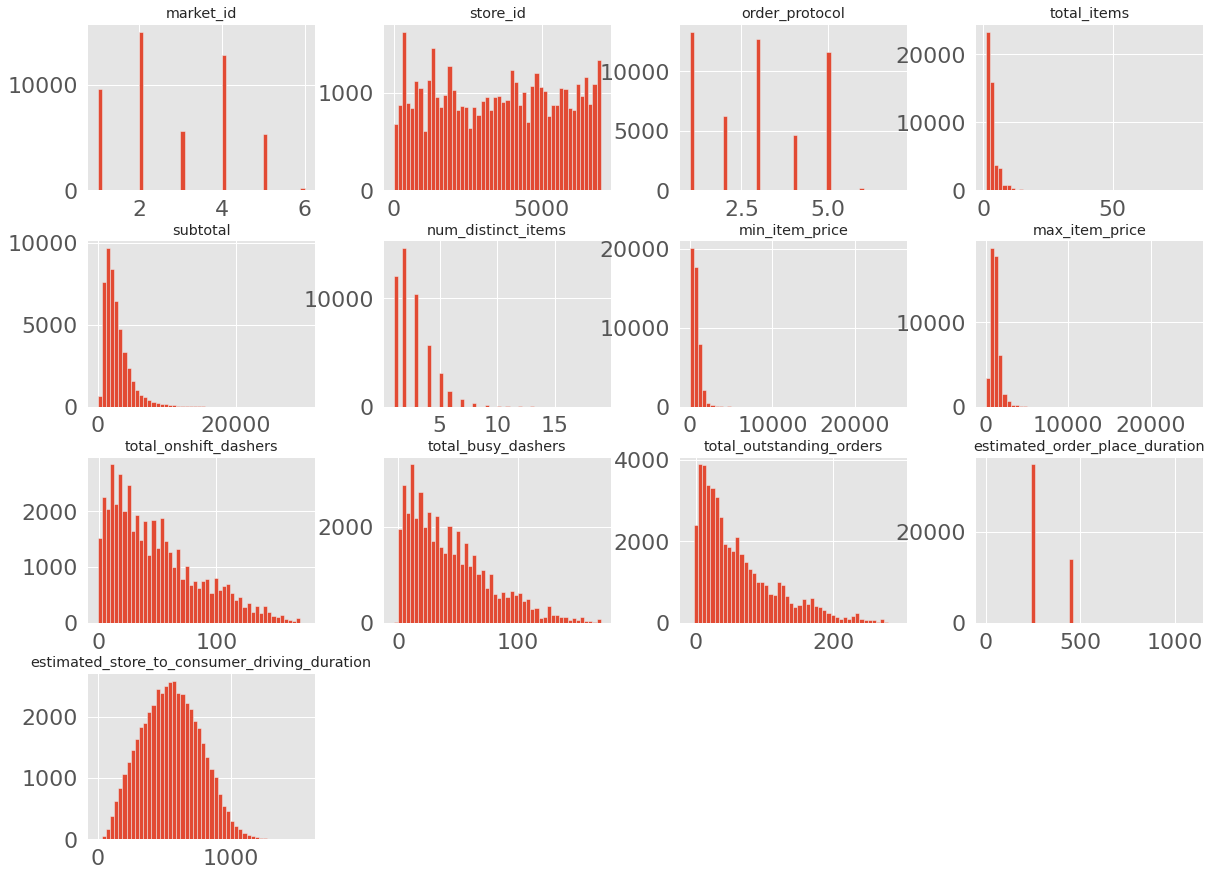

In [ ]:
# histogram of the plot
door_test.hist(bins=50, figsize=(20,15))

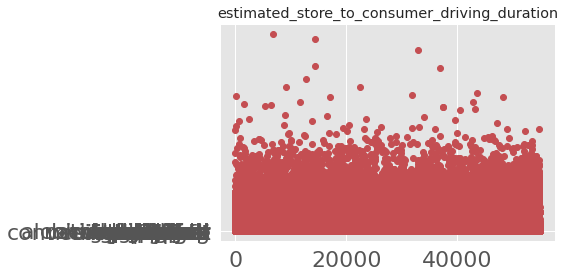

In [ ]:
# Data Cleaning and Wrangling
plt.plot(door_test[names2[0]],'r.')
plt.title(names2[0])

plt.plot(door_test[names2[2]],'ro')
plt.title(names2[2])

plt.plot(door_test[names2[3]],'ro')
plt.title(names2[3])

plt.plot(door_test[names2[4]],'ro')
plt.title(names2[4])

plt.plot(door_test[names2[5]],'ro')
plt.title(names2[5])

plt.plot(door_test[names2[6]],'ro')
plt.title(names2[6])

b = door_test.index[door_test["num_distinct_items"] == 0].tolist()
plt.plot(door_test[names2[7]],'ro')
plt.title(names2[7])
sum(door_test["min_item_price"] > door_test["max_item_price"])

c = door_test.index[door_test["min_item_price"] > door_test["max_item_price"]]
plt.plot(door_test[names2[8]],'ro')
plt.title(names2[8])

d = door_test.index[door_test["max_item_price"] == max(door_test["max_item_price"])].tolist()
e = door_test.index[door_test["max_item_price"] > door_test["subtotal"]]
plt.plot(door_test[names2[9]],'r.')
plt.title(names2[9])
plt.plot(door_test[names2[10]],'r.')
plt.title(names2[10])
f = door_test.index[door_test["total_busy_dashers"] > door_test["total_onshift_dashers"]]
plt.plot(door_test[names2[11]],'r.')
plt.title(names2[11])
plt.plot(door_test[names2[12]],'ro')
plt.title(names2[12])
plt.plot(door_test[names2[13]],'ro')
plt.title(names2[13])
plt.plot(door_test[names2[14]],'ro')
plt.title(names2[14])

a1 = door_test.index[(door_test["min_item_price"] > door_test["max_item_price"]) & (door_test["total_items"]==1)].tolist()
list1 = ["min_item_price","max_item_price"]
for n in range(0,len(list1)):
    for i in range(0,len(a1)):
        door_test[list1[n]][a1[i]] = door_test["subtotal"][a1[i]]

a2 = door_test.index[(door_test["min_item_price"] > door_test["max_item_price"]) & (door_test["total_items"]==2) & ((door_test["subtotal"] - door_test["min_item_price"]) < door_test["min_item_price"])].tolist()
for n in range(0, len(a2)):
    door_test["max_item_price"][a2[n]] = door_test["min_item_price"][a2[n]]
    door_test["min_item_price"][a2[n]] = door_test["subtotal"][a2[n]] - door_test["max_item_price"][a2[n]]
    
a3 = door_test.index[(door_test["min_item_price"] > door_test["max_item_price"]) & (door_test["total_items"]==2) & ((door_test["subtotal"] - door_test["min_item_price"]) > door_test["min_item_price"])].tolist()
for n in range(0, len(a3)):
    door_test["max_item_price"][a3[n]] = door_test["subtotal"][a3[n]] - door_test["min_item_price"][a3[n]]

a4 = door_test.index[door_test["min_item_price"] > door_test["max_item_price"]].tolist()
for n in range(0, len(a4)):
    tp = door_test["max_item_price"][a4[n]].copy()
    door_test["max_item_price"][a4[n]] = door_test["min_item_price"][a4[n]]
    door_test["min_item_price"][a4[n]] = tp

a5 = door_test.index[door_test["min_item_price"]<0].tolist()
for n in range(0, len(a5)):
    door_test["min_item_price"][a5[n]] = abs(door_test["min_item_price"][a5[n]])

a6 = door_test.index[door_test["total_onshift_dashers"]<0].tolist()
for n in range(0, len(a6)):
    door_test["total_onshift_dashers"][a6[n]] = abs(door_test["total_onshift_dashers"][a6[n]])
    
a7 = door_test.index[door_test["total_busy_dashers"] > door_test["total_onshift_dashers"]].tolist()
for n in range(0, len(a7)):
    tp1 = door_test["total_onshift_dashers"][a7[n]].copy()
    door_test["total_onshift_dashers"][a7[n]] = door_test["total_busy_dashers"][a7[n]]
    door_test["total_busy_dashers"][a7[n]] = tp1

a8 = door_test.index[door_test["total_outstanding_orders"]<0].tolist()   
for n in range(0, len(a8)):
    door_test["total_outstanding_orders"][a8[n]] = abs(door_test["total_outstanding_orders"][a8[n]])

a10 = door_test.index[door_test["max_item_price"] > door_test["subtotal"]].tolist()
for n in range(0, len(a10)):
    door_test["subtotal"][a10[n]] = np.mean(door_test["max_item_price"][a10[n]] + door_test["min_item_price"][a10[n]])*door_test["total_items"][a10[n]]


door_test["created_at"] = pd.to_datetime(door_test["created_at"], format='%Y-%m-%d %H:%M:%S', errors='raise')

door_test["created_at_hour"] = (door_test["created_at"].dt.hour)*3600
door_test["created_at_minutes"] = (door_test["created_at"].dt.minute)*60
door_test["created_at_seconds"] = door_test["created_at"].dt.second
door_test["created_at_dayofweek"] = door_test["created_at"].dt.dayofweek
pd.set_option("display.max_columns", 6)
door_test["created_at_time"] = door_test["created_at_hour"] + door_test["created_at_minutes"] + door_test["created_at_seconds"]
door_test[["created_at", "created_at_hour", "created_at_minutes", "created_at_seconds", "created_at_dayofweek", "created_at_time"]].head()
door_test["created_at_sine_time"] = np.sin(2*np.pi*door_test["created_at_time"]/(24*60*60))
door_test["created_at_cos_time"] = np.cos(2*np.pi*door_test["created_at_time"]/(24*60*60))
door_test["total_available_dasher"] = door_test["total_onshift_dashers"] - door_test["total_busy_dashers"]
cat_columns = ["market_id", "store_primary_category", "order_protocol", "created_at_dayofweek"]
door_test.drop("created_at", axis=1, inplace=True)
test_x = pd.get_dummies(door_test, prefix_sep="__", columns=cat_columns)
names3 = test_x.columns

# scaling data
scaler = MinMaxScaler()
scaler.fit(test_x)
test_x = scaler.transform(test_x)
test_x = pd.DataFrame(test_x, columns=names3)

# selecting best subset
test_x = test_x[Sig_Features]
type(test_x)

In [ ]:
# test set model run
prediction_test = regressor.predict(test_x)  # duration time in seconds

print(prediction_test)

[3481.5723 3181.948  4149.541  ... 2807.6028 3226.8337 3530.7485]


In [ ]:
#door_test = pd.read_csv('predict_data.csv')
path = '/content/gdrive/MyDrive/DoorDash Challenge/predict_data.csv'

door_test = pd.read_csv(path)


door_test.dropna(how='any',axis=0, inplace=True)
door_test["created_at"] = pd.to_datetime(door_test["created_at"], format='%Y-%m-%d %H:%M:%S', errors='raise')
Actual_Delivery_time = door_test["created_at"] + pd.to_timedelta(prediction_test, unit='s') # adding the duration time to created_at time
I_d = door_test["delivery_id"]
results = pd.DataFrame(I_d)
results["prediction_duration(seconds)"] = prediction_test
results["Actual_DeliveActual_Delivery_time

results.to_csv('data_to_predict.csv', 
               index=None, 
               header=True,
               date_format='%Y-%m-%d %H:%M:%S')int(results)

<div id="conclusion">
    <h3>Conclusion</h3> 
</div>

At the end of this project, I was able to build a model to predict the total duration delivery seconds using
Machine Learning by generating additional features. I was able to make prediction and monitor prediction for 
effective customer service and satisfaction. This model can be fine-tuned and streamlined into the existing 
process to aid decision making in business.